In [16]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sc
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

add_data = "/home/cccr/roxy/matin/MTech_project/data/"

def filter_signal_scipy(signal,sample_freq,ltime_period,htime_period,keep_mean):
    filter_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf=1./ltime_period
        lf=1./htime_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1=(np.abs(fftfreq) >= lf) & (np.abs(fftfreq) <= hf)  
        inv_fft=np.zeros(temp_fft.size,dtype=complex)
        inv_fft[i1]=temp_fft[i1]
        if keep_mean:
            inv_fft[0]=temp_fft[0]
        filter_signal= np.real_if_close(sc.fftpack.ifft(inv_fft))
    
    return filter_signal

def norm_anom_var(var):
    mean_var = np.mean(var)
    anom_var = var - mean_var
    std_var = np.std(var)
    norm_anom_var = anom_var / std_var
    return norm_anom_var

rf = xr.open_dataarray(add_data + "rfmm1_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
rf = rf[:,40:90,80:130]
rf = rf[:,12:-13,5:-6]

sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]


n_rf = rf
for i in range(0,39):
    for j in range(0,25):
        n_rf[:,j,i] = norm_anom_var(rf[:,j,i])
n_sst = sst        
for i in range(0,39):
    for j in range(0,25):
        n_sst[:,j,i] = norm_anom_var(sst[:,j,i])


sample_freq = 1
ltime_period = 30
htime_period = 60
keep_mean = 0

filtered_rf = n_rf
for i in range(0,39):
    for j in range(0,25):
        filtered_rf[:,j,i] = filter_signal_scipy(n_rf[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)
filtered_sst = n_sst
for i in range(0,39):
    for j in range(0,25):
        if any(np.isnan(n_sst[:,j,i].values)):
            pass
        else:
            filtered_sst[:,j,i] = filter_signal_scipy(n_sst[:,j,i].values, sample_freq,
                                              ltime_period, htime_period, keep_mean)

In [17]:
rf = xr.open_dataarray(add_data + "rfmm1_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
rf = rf[:,40:90,80:130]
rf = rf[:,12:-13,5:-6]

sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]


sst_mon = sst.isel(time=sst.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
rf_mon = rf.isel(time=rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
Fsst_mon = filtered_sst.isel(time=filtered_sst.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
Frf_mon = filtered_rf.isel(time=filtered_rf.time.dt.month.isin([5, 6, 7, 8, 9, 10]))

sst_mean = Fsst_mon.mean(dim = ['lon', 'lat'])[-360:-184]
rf_mean = Frf_mon.mean(dim = ['lon', 'lat'])[-360:-184]
rf_std = rf_mean.std().data
sst_std = sst_mean.std().data

print("First Std Deviation for SST monsoon DATA = ",sst_mean.std().data)
print("First Std Deviation for RF monsoon DATA = ",rf_mean.std().data)


First Std Deviation for SST monsoon DATA =  0.10301461815834045
First Std Deviation for RF monsoon DATA =  0.20963849127292633


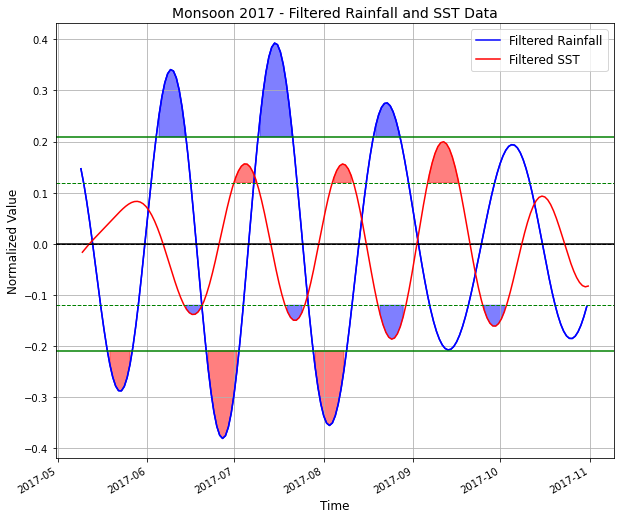

In [19]:
plt.figure(figsize=[10,8])

# Plot filtered rainfall data
rainfall_mean = Frf_mon.mean(dim = ['lon', 'lat'])[-360:-184]
filtered_rf = xr.DataArray(rainfall_mean, coords={"time":rainfall_mean.time},dims=["time"])
x = filtered_rf.time.data
y = filtered_rf.data
filtered_rf.plot(color = 'b', label='Filtered Rainfall')
sns.lineplot(x=x, y=y, color='b')
plt.axhline(y=0, color='black')
plt.axhline(y=0.209, color='g')
plt.axhline(y=-0.209, color='g')
above_threshold = y > 0.209
below_threshold = y < -0.209
plt.fill_between(x, y, 0.209, where=above_threshold, color='blue', alpha=0.5)
plt.fill_between(x, y, -0.209, where=below_threshold, color='red', alpha=0.5)


# Plot filtered SST data
sst_mean = Fsst_mon.mean(dim = ['lon', 'lat'])[-360:-184]
filtered_sst = xr.DataArray(sst_mean, coords={"time":sst_mean.time},dims=["time"])
x = filtered_sst.time.data
y = filtered_sst.data
filtered_sst.plot(color = 'r', label='Filtered SST')

# Add horizontal lines and fill color between them
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.120, color='g', linestyle='--', linewidth=1)
plt.axhline(y=-0.120, color='g', linestyle='--', linewidth=1)
above_threshold = y > 0.120
below_threshold = y < -0.120
plt.fill_between(x, y, 0.120, where=above_threshold, color='red', alpha=0.5)
plt.fill_between(x, y, -0.120, where=below_threshold, color='blue', alpha=0.5)

# Set axis labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title("Monsoon 2017 - Filtered Rainfall and SST Data", fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True)

# Save figure
#plt.savefig("CombinedSSTRF2017.png")


In [34]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

 
import tensorflow.compat.v1 as tf

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-01-01","2018-12-31"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out

channels = ["SIFilteredrfBOB_6lag.nc","SIFilteredSSTBOB_6.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "SIFilteredrfBOB_6lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target


def In_Out(lead_time):
    channels = ["SIFilteredrfBOB_6lag.nc","SIFilteredSSTBOB_6.nc"]
    steps = 7

    # Create input for the model
    input = create_input(channels, steps)

    # Preprocess target data
    channel_data = xr.open_dataarray(add_data + "SIFilteredrfBOB_6lag.nc")
    _, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
    target = np.expand_dims(target, axis=1)

    # Roll axes for input and target
    x = np.rollaxis(input, 4, 2)
    x = np.rollaxis(x, 4, 2)

    y = np.rollaxis(target, 3, 1)
    y = np.rollaxis(y, 3, 1)

    # Assert that input and target shapes are consistent
    assert input.shape[0] == target.shape[0]
    assert input.shape[-1] == target.shape[-1]
    assert input.shape[-2] == target.shape[-2]


    # Print shape of input and target
    print("INPUT SHAPE --> ", input.shape)
    print("TARGET SHAPE --> ", target.shape)
  
    # Delete original input and target variables to free up memory
    del input
    del target
    return x,y


Adding channel 0 with shape: (237, 7, 1, 25, 39)
Adding channel 1 with shape: (237, 7, 1, 25, 39)
INPUT SHAPE -->  (237, 7, 2, 25, 39)
TARGET SHAPE -->  (237, 1, 25, 39)


In [38]:

save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/"

model1 = ['7in1out/ConvLstm_sst13rf_rf_0SI.h5','7in2out/ConvLstm_sst13rf_rf_1SI.h5','7in3out/ConvLstm_sst13rf_rf_2SI.h5', '7in4out/ConvLstm_sst13rf_rf_3SI.h5', '7in5out/ConvLstm_sst13rf_rf_4SI.h5','7in6out/ConvLstm_sst13rf_rf_5SI.h5', '7in7out/ConvLstm_sst13rf_rf_6SI.h5']

model2 = ['7in1out/ConvLstm_sst0rf_rf_0SI.h5','7in2out/ConvLstm_sst0rf_rf_1SI.h5','7in3out/ConvLstm_sst0rf_rf_2SI.h5', '7in4out/ConvLstm_sst0rf_rf_3SI.h5', '7in5out/ConvLstm_sst0rf_rf_4SI.h5', '7in6out/ConvLstm_sst0rf_rf_5SI.h5', '7in7out/ConvLstm_sst0rf_rf_6SI.h5']

mod1 = []

for i in model1:
    lead_time = model1.index(i)
    x,y = In_Out(lead_time)
    model = tf.keras.models.load_model(save_path + i)
    pred = model.predict(x)

    actual = y.flatten()
    prediction = pred.flatten()
    corr = np.corrcoef(actual,prediction)
    mod1.append(corr)

mod1


Adding channel 0 with shape: (237, 7, 1, 25, 39)
Adding channel 1 with shape: (237, 7, 1, 25, 39)
INPUT SHAPE -->  (237, 7, 2, 25, 39)
TARGET SHAPE -->  (237, 1, 25, 39)
8/8 [==============================] - 2s 122ms/step
Adding channel 0 with shape: (236, 7, 1, 25, 39)
Adding channel 1 with shape: (236, 7, 1, 25, 39)
INPUT SHAPE -->  (236, 7, 2, 25, 39)
TARGET SHAPE -->  (236, 1, 25, 39)
8/8 [==============================] - 1s 84ms/step
Adding channel 0 with shape: (235, 7, 1, 25, 39)
Adding channel 1 with shape: (235, 7, 1, 25, 39)
INPUT SHAPE -->  (235, 7, 2, 25, 39)
TARGET SHAPE -->  (235, 1, 25, 39)
8/8 [==============================] - 1s 85ms/step
Adding channel 0 with shape: (234, 7, 1, 25, 39)
Adding channel 1 with shape: (234, 7, 1, 25, 39)
INPUT SHAPE -->  (234, 7, 2, 25, 39)
TARGET SHAPE -->  (234, 1, 25, 39)
8/8 [==============================] - 1s 84ms/step
Adding channel 0 with shape: (233, 7, 1, 25, 39)
Adding channel 1 with shape: (233, 7, 1, 25, 39)
INPUT SHAPE -

[array([[1.        , 0.86240535],
        [0.86240535, 1.        ]]),
 array([[1.        , 0.01897931],
        [0.01897931, 1.        ]]),
 array([[1.        , 0.01709859],
        [0.01709859, 1.        ]]),
 array([[1.        , 0.01787093],
        [0.01787093, 1.        ]]),
 array([[1.        , 0.79098019],
        [0.79098019, 1.        ]]),
 array([[1.        , 0.01794067],
        [0.01794067, 1.        ]]),
 array([[1.        , 0.01893534],
        [0.01893534, 1.        ]])]

In [40]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

 
import tensorflow.compat.v1 as tf

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-01-01","2018-12-31"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out



channels = ["SIFilteredrfBOB_0lag.nc","SIFilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "SIFilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target

def In_Out(lead_time):
    channels = ["SIFilteredrfBOB_0lag.nc","SIFilteredSSTBOB_0.nc"]
    steps = 7

    # Create input for the model
    input = create_input(channels, steps)
 
    # Preprocess target data
    channel_data = xr.open_dataarray(add_data + "SIFilteredrfBOB_0lag.nc")
    _, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
    target = np.expand_dims(target, axis=1)

    # Roll axes for input and target
    x = np.rollaxis(input, 4, 2)
    x = np.rollaxis(x, 4, 2)

    y = np.rollaxis(target, 3, 1)
    y = np.rollaxis(y, 3, 1)

    # Assert that input and target shapes are consistent
    assert input.shape[0] == target.shape[0]
    assert input.shape[-1] == target.shape[-1]
    assert input.shape[-2] == target.shape[-2]


    # Print shape of input and target
    print("INPUT SHAPE --> ", input.shape)
    print("TARGET SHAPE --> ", target.shape)
  
    # Delete original input and target variables to free up memory
    del input
    del target
    return x,y


Adding channel 0 with shape: (237, 7, 1, 25, 39)
Adding channel 1 with shape: (237, 7, 1, 25, 39)
INPUT SHAPE -->  (237, 7, 2, 25, 39)
TARGET SHAPE -->  (237, 1, 25, 39)


In [41]:
mod2 = []

for i in model2:
    lead_time = model2.index(i)
    x,y = In_Out(lead_time)
    model = tf.keras.models.load_model(save_path + i)
    pred = model.predict(x)

    actual = y.flatten()
    prediction = pred.flatten()
    corr = np.corrcoef(actual,prediction)
    mod2.append(corr)


Adding channel 0 with shape: (237, 7, 1, 25, 39)
Adding channel 1 with shape: (237, 7, 1, 25, 39)
INPUT SHAPE -->  (237, 7, 2, 25, 39)
TARGET SHAPE -->  (237, 1, 25, 39)
8/8 [==============================] - 2s 88ms/step
Adding channel 0 with shape: (236, 7, 1, 25, 39)
Adding channel 1 with shape: (236, 7, 1, 25, 39)
INPUT SHAPE -->  (236, 7, 2, 25, 39)
TARGET SHAPE -->  (236, 1, 25, 39)
8/8 [==============================] - 1s 86ms/step
Adding channel 0 with shape: (235, 7, 1, 25, 39)
Adding channel 1 with shape: (235, 7, 1, 25, 39)
INPUT SHAPE -->  (235, 7, 2, 25, 39)
TARGET SHAPE -->  (235, 1, 25, 39)
8/8 [==============================] - 2s 89ms/step
Adding channel 0 with shape: (234, 7, 1, 25, 39)
Adding channel 1 with shape: (234, 7, 1, 25, 39)
INPUT SHAPE -->  (234, 7, 2, 25, 39)
TARGET SHAPE -->  (234, 1, 25, 39)
8/8 [==============================] - 2s 149ms/step
Adding channel 0 with shape: (233, 7, 1, 25, 39)
Adding channel 1 with shape: (233, 7, 1, 25, 39)
INPUT SHAPE -

In [42]:
mod2

[array([[1.        , 0.01590185],
        [0.01590185, 1.        ]]),
 array([[1.        , 0.84253291],
        [0.84253291, 1.        ]]),
 array([[1.        , 0.01941808],
        [0.01941808, 1.        ]]),
 array([[1.        , 0.01914714],
        [0.01914714, 1.        ]]),
 array([[1.        , 0.68914399],
        [0.68914399, 1.        ]]),
 array([[1.        , 0.01871628],
        [0.01871628, 1.        ]]),
 array([[1.        , 0.01974334],
        [0.01974334, 1.        ]])]

In [28]:
model = ['7','6','5']
model.index('6')

1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = [10,8])
# Generate some data
x = np.arange(0, 7, 1)
y1 = [0.94, 0.84, 0.82, 0.81, 0.61, 0.46, 0.48]

y2 = [0.90, 0.87, 0.71, 0.62, 0.67, 0.42, 0.56]

# Plot the data
plt.plot(x, y1, color='#8fb6b8', linestyle='-', linewidth=2, label='Model With 13 day lag')
plt.plot(x, y2, color='#d182a2', linestyle='--', linewidth=2, label='Model With 0 day lag')

# Add a title, legend, and labels to the plot
plt.title('Model Result', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('Lead Time', fontsize=14)
plt.ylabel('Correlation between Actual and Predictive Values', fontsize=14)

# Customize the axes ticks and grid lines
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.5)

# Add some annotations to the plot
#plt.text(4, 20, 'Line 1', fontsize=14, color='#8fb6b8')
#plt.text(2, 31, 'Line 2', fontsize=14, color='#d182a2')
#plt.annotate('Intersection', xy=(2.6, 8.8), xytext=(3.5, 13),arrowprops=dict(facecolor='black', shrink=0.05))

# Add a background color to the plot
ax = plt.gca()
ax.set_facecolor('#f0f0f0')

# Show the plot
plt.savefig("Model_Performance")
plt.show()